<a href="https://colab.research.google.com/github/pythonic1exe/Cat-vs-Dog-Recognition/blob/main/CatvsDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow scikit-learn matplotlib seaborn

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# for downloading dataset and storing it in colab

import kagglehub, shutil, os

path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Downloaded to:", path)

dest = "/content/data"

if os.path.exists(dest):
    shutil.rmtree(dest)
shutil.copytree(path, dest)

print("Dataset ready at:", dest)
print("Contents:", os.listdir(dest))


Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Downloaded to: /kaggle/input/dog-and-cat-classification-dataset
Dataset ready at: /content/data
Contents: ['PetImages']


In [106]:
import tensorflow as tf # for reading and decoding imgs
import os # for folder handling
from PIL import Image

def clean_with_tensorflow_decoder(data_dir): # func to remove corrupted files

    removed = 0
    processed = 0

    for category in ["Cat", "Dog"]: # ietrate through both categories
        folder = os.path.join(data_dir, category) # path to each folder(cat/dog)
        if not os.path.exists(folder):# skip if it doesnt exist
            continue

        print(f"Processing {category} images with TensorFlow decoder...")

        files = os.listdir(folder) # list of all filenames in folder
        total_files = len(files) # total no of imgs

        for i, fname in enumerate(files): # loop through each file in folder
            fpath = os.path.join(folder, fname) # build full file path
            processed += 1

            if (processed) % 500 == 0: # print after every 500 imgs
                print(f"  Processed {processed} files, removed {removed} corrupted files...")

            try:
                image_raw = tf.io.read_file(fpath) # reads raw file bytes and converts to tensor form

                # decodes the raw bytes into an image tensor
                # forces the tensor thru 3 channels(RGB)
                # treats GIFs etc as single frame expand_animations=False
                image = tf.image.decode_image(image_raw, channels=3, expand_animations=False)

                image = tf.cast(image, tf.float32) # converts tensor to float so that it is in compatible training form

                shape = tf.shape(image) # height, width, channels
                if tf.reduce_any(tf.equal(shape, 0)): # if dimension 0
                    raise ValueError("Image has zero dimension") # raise error, image is invalid

            except Exception as e: # if try fails
                print(f"    Removing: {fname} - Error: {str(e)[:100]}") # print a 100 char erro msg
                try:
                    os.remove(fpath) # tries to delete the bad file which would disrupt the training model
                    removed += 1 # increment
                except:
                    pass # if not skip, did not happen btw

    print(f"\nTensorFlow cleaning completed:")
    print(f"- Processed {processed} images")
    print(f"- Removed {removed} problematic images")

    return removed # returns number of removed files

In [107]:
def verify_clean_dataset(data_dir): # debugger for above function

    print("\nVerifying cleaned dataset...")
    try:
        test_ds = tf.keras.utils.image_dataset_from_directory( # test data set
            data_dir, # data, received from func argument
            validation_split=0.1, # 10% for validation testing
            subset="training", # loads training portion
            seed=42, # to ensure data is random and reproducible
            image_size=(64, 64), # 64 x 64 img size
            batch_size=1 # process 1 img at a time (for debugging)
        )

        for i, (image, label) in enumerate(test_ds.take(5)): # loops through 5 imgs from test dataset
            print(f"  Sample {i+1}: Shape = {image.shape}, Label = {label.numpy()}") # prints img tensor shape and label

        print(" Dataset verification successful!")
        return True

    except Exception as e:
        print(f" Dataset verification failed: {e}")
        return False

In [108]:
data_dir = "/content/data/PetImages" # dataset directory
removed_count = clean_with_tensorflow_decoder(data_dir) # no of removed imgs from our defined func

verification_passed = verify_clean_dataset(data_dir) # debug

if verification_passed: # is True, yes we succeeded :)
    print("\n Ready to create your full dataset!")
else: # else we failed :(
    print("\n Still have issues. Let's try a more aggressive approach...")

Processing Cat images with TensorFlow decoder...
  Processed 500 files, removed 0 corrupted files...
  Processed 1000 files, removed 0 corrupted files...
  Processed 1500 files, removed 0 corrupted files...
    Removing: 4351.jpg - Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input s
  Processed 2000 files, removed 1 corrupted files...
  Processed 2500 files, removed 1 corrupted files...
  Processed 3000 files, removed 1 corrupted files...
  Processed 3500 files, removed 1 corrupted files...
  Processed 4000 files, removed 1 corrupted files...
  Processed 4500 files, removed 1 corrupted files...
  Processed 5000 files, removed 1 corrupted files...
  Processed 5500 files, removed 1 corrupted files...
  Processed 6000 files, removed 1 corrupted files...
  Processed 6500 files, removed 1 corrupted files...
  Processed 7000 files, removed 1 corrupted files...
  Processed 7500 files, removed 1 corrupted files...
  Processed 8000 files, 

In [109]:
img_size = (128, 128) # 128 x 128 img size
batch_size = 32 # process 32 imgs at a time for mini batch gradient descent
seed = 42 # randomness and reproducibility

In [110]:
# training data loaded
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# validation data loaded
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 24929 files belonging to 2 classes.
Using 19944 files for training.
Found 24929 files belonging to 2 classes.
Using 4985 files for validation.


In [111]:
class_names = raw_train_ds.class_names # category names in our dataset
print("Class names:", class_names)

Class names: ['Cat', 'Dog']


In [112]:
val_batches = tf.data.experimental.cardinality(raw_val_ds) # total img / gd batch size = batch size. Ours is 624
test_ds = raw_val_ds.take(val_batches // 2) # first half of validation for testing
val_ds = raw_val_ds.skip(val_batches // 2) # second half of validation allocated for validation

In [113]:
normalization_layer = tf.keras.layers.Rescaling(1./255) # a layer to rescale pixel value 0-255, its for RGB, after this, values are between 0 n 1

# .map() used for transforming
# x: imgs
# y: labels
# lambda x, y : for every batch (includes x n y), pass x(imgs) through normalization layer and keep labels unchanged
# do it for training, validation and testing datasets
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [114]:
# preftch? preparing the next batch of data in the background while the model is busy training on the current batch.
# without it, cpu has to stop, wait for one batch to complete iteration, then loads other batch
# AUTOTUNE is for determining how many batches to keep ready in background depending on CPU/GPU
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

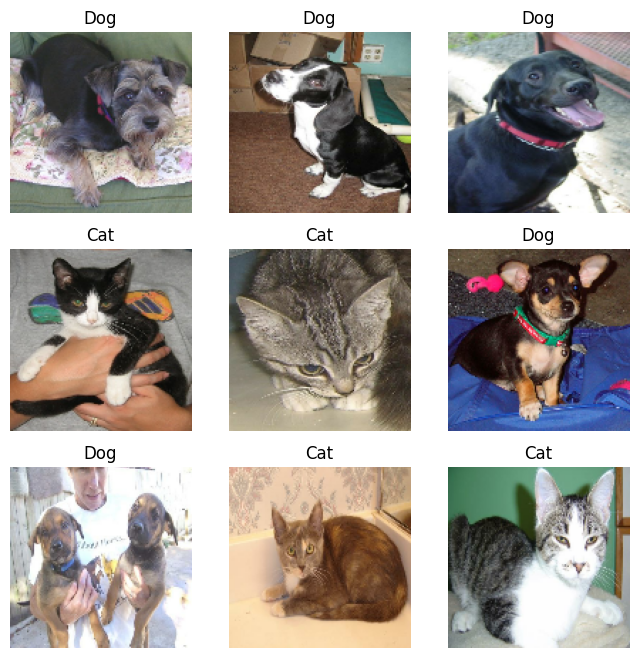

In [115]:
plt.figure(figsize=(8, 8)) # matplotlib 8x8 figure
for images, labels in raw_train_ds.take(1): # take one batch from training data
    for i in range(9): # iterate over 9 imgs
        ax = plt.subplot(3, 3, i + 1) # 3x3 grid with img at i+1 index
        plt.imshow(images[i].numpy().astype("uint8")) # takes tensor of img, converts to numpy array and ensures its pixel values between 0-255
        plt.title(class_names[labels[i]]) # img title
        plt.axis("off") # dont show axes


In [116]:
from tensorflow.keras import layers

In [117]:
# for image augmentation
# image augmentation is taking img from training data and applying random transformation on it like flipping, rotating etc
# it is done to teach the model how to recognize same object in different conditions
# sequential model, not actual CNN but a preprocessing pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # random flips
    layers.RandomRotation(0.1), # random rotation
    layers.RandomZoom(0.1), # random zoom
    layers.RandomBrightness(factor=0.2) # random brightness
])

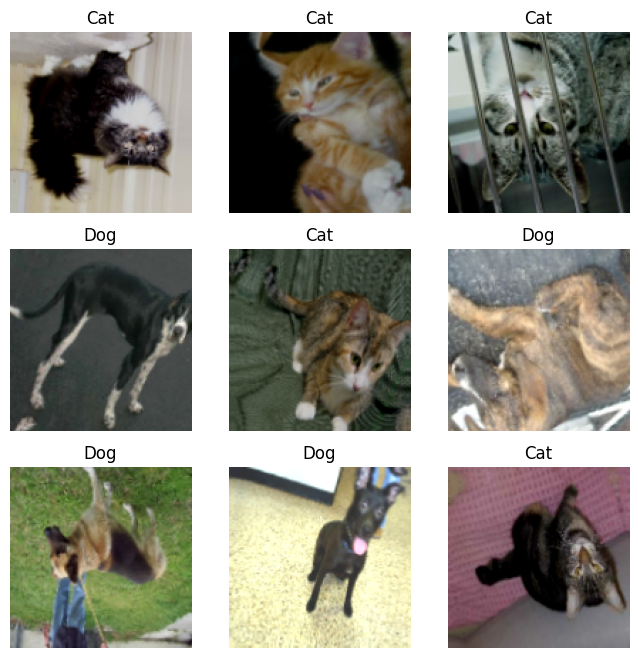

In [118]:
# show augmented images to see difference vs orginal images
plt.figure(figsize=(8, 8))
for images, labels in raw_train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images)[i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [151]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [159]:
# CNN model architecture
def create_model_for_original_datasets(): # func to build CNN architecture

    # sequential model, so that layers can be stacked up on each other
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)), # Input layer 128x128 img with 3 dimensions, RGB

        # 1st convolution layer
        # 32 filters of 3x3 size
        # activation func is ReLu for non linearity
        # padding='same' : means output and input size be same
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2), # pooling with 2x2 window
        tf.keras.layers.Dropout(0.1), # randomly drop 10% neurons

        # 2nd convolution layer
        # 64 filters with 3x3 size
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.1),

        # 3rd convolution layer
        # 128 filters with 3x3 size
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.2), # randomly drop 20% neurons

        # classifier layer
        # takes input from last layer and reduces it to 1d vector
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'), # dense layer with 64 neurons
        tf.keras.layers.Dropout(0.3), # randomly drop 30% neurons for regularization purpose

        # last layer
        # a single neuron with sigmoid activation
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model # return CNN

In [160]:
original_model = create_model_for_original_datasets() # save model into a var

In [161]:
# compile model
original_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam: Adaptive learning rate optimizer, it controls the weight updates after each batch
    loss='binary_crossentropy', # loss function
    metrics=['accuracy', 'precision', 'recall'] # metrics
)

print("✅ Model created to work with your original train_ds and val_ds")
print("📊 This will use your proper train/val split and all your data")
original_model.summary()

✅ Model created to work with your original train_ds and val_ds
📊 This will use your proper train/val split and all your data


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
# callbacks keep an eye on the training of model, it saves the best model to our told destination
callbacks = [
    tf.keras.callbacks.EarlyStopping( # stop training when model stops improving.
        monitor='val_accuracy', # monitors validation accuracy
        patience=5, # wait for 5 epochs
        restore_best_weights=True, # rollback to last best weights
        verbose=1 # prints message whn it stops
    ),
    tf.keras.callbacks.ModelCheckpoint( # for saving the model during training
        filepath='/content/best_original_datasets_model.keras',
        monitor='val_accuracy',
        save_best_only=True, # save the best epoch only
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau( # for lowering the learning rate automatically when training gets stuck.
        monitor='val_loss', # monitor validation loss
        factor=0.5, # multiply learning rate by 0.5, reducing it by half
        patience=3, # wait 3 epochs
        min_lr=1e-6, # never go below this learning rate
        verbose=1 # makes the adjustments
    )
]

In [163]:
print("\n🚀 Training with your original train_ds and val_ds...")
print("📈 Expected: Better than 69% since we're using more data and proper splits")

history_original = original_model.fit( # train model
    train_ds, # training dataset
    validation_data=val_ds, # validation dataset
    epochs=20,
    callbacks=callbacks,
    verbose=1 # print progress wrt to each epoch
)


🚀 Training with your original train_ds and val_ds...
📈 Expected: Better than 69% since we're using more data and proper splits
Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5410 - loss: 0.6840 - precision: 0.5373 - recall: 0.5462
Epoch 1: val_accuracy improved from -inf to 0.60747, saving model to /content/best_original_datasets_model.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5410 - loss: 0.6840 - precision: 0.5373 - recall: 0.5461 - val_accuracy: 0.6075 - val_loss: 0.6443 - val_precision: 0.5894 - val_recall: 0.7200 - learning_rate: 0.0010
Epoch 2/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6109 - loss: 0.6495 - precision: 0.6470 - recall: 0.4715
Epoch 2: val_accuracy improved from 0.60747 to 0.64845, saving model to /content/best_original_datasets_model.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6109 - loss: 0.6494 - precision: 0.6471 - recall: 0.4716 - val_accuracy: 0.6485 - val_loss: 0.6199 - val_precisio

In [164]:
final_results = original_model.evaluate(val_ds, verbose=0) # run the trained model on validation dataset
print(f"\n🎊 RESULTS with original datasets:")
print(f"📊 Validation Accuracy: {final_results[1]:.1%}")
print(f"📊 Precision: {final_results[2]:.3f}")
print(f"📊 Recall: {final_results[3]:.3f}")


🎊 RESULTS with original datasets:
📊 Validation Accuracy: 86.8%
📊 Precision: 0.898
📊 Recall: 0.833
